# Comparing the baseline dataset vs our feature engineered dataset

In this notebook, we're comparing the baseline dataset that was provided to use at the beginning of the hackathon with the dataset that we created and tailored with some new features. We will be comparing the two best models :

- QRF
- XGBQRF


In [115]:
import os
import sys

import joblib
import numpy as np
import pandas as pd
from timeit import default_timer as timer 

from quantile_forest import RandomForestQuantileRegressor

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..")))

from src.utils.model import (
    split_dataset,
    compare_models_per_station,
    XGBQRFModel,
)

from src.utils.helpers import check_columns_exist, get_y_train

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"
SEED = 42
NUMBER_OF_WEEK = 4  # Number of weeks to predict one model is trained per week
QUANTILES = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

INPUT_DIR = os.path.join("..", "..", "..", "data", "input")
BASELINE_DATASET_NAME = "dataset_baseline.csv"
CUSTOM_DATASET_NAME = "dataset_custom.csv"
BASELINE_DATASET_PATH = os.path.join(INPUT_DIR, BASELINE_DATASET_NAME)
CUSTOM_DATASET_PATH = os.path.join(INPUT_DIR, CUSTOM_DATASET_NAME)
DATASET_TYPES = ["baseline", "custom"]
DATASETS = {}

best_params_qrf = {
    "n_estimators": 130,
    "min_samples_split": 30,
    "min_samples_leaf": 20,
    "max_features": None,
    "max_depth": 30,
    "bootstrap": True,
}

best_params_xgb = {
    "subsample": 0.6,
    "n_estimators": 300,
    "min_child_weight": 5,
    "max_depth": 5,
    "learning_rate": 0.05,
    "gamma": 0.1,
    "colsample_bytree": 0.8,
}

# Will be used for comparison later on
summary = {}

In [117]:
for dataset_type in DATASET_TYPES:
    if dataset_type == "baseline":
        dataset_path = BASELINE_DATASET_PATH
    else:
        dataset_path = CUSTOM_DATASET_PATH

    # Load dataset
    dataset = pd.read_csv(dataset_path)

    # Check if columns exist
    check_columns_exist(dataset, ["ObsDate", "station_code"])

    # Set index to ObsDate
    dataset = dataset.set_index("ObsDate")

    # Split dataset into train and test sets
    train_split, spatio_temporal_split, temporal_split = split_dataset(
        dataset, 0.75, TIME_VALIDATION
    )

    # Get X and y for training and testing
    x_train, y_train = get_y_train(train_split.drop(columns=["station_code"]))
    x_test, y_test = get_y_train(spatio_temporal_split.drop(columns=["station_code"]))
    x_eval, y_eval = get_y_train(temporal_split)

    summary[dataset_type] = {}

    DATASETS[dataset_type] = {
        "x_train": x_train,
        "y_train": y_train,
        "x_test": x_test,
        "y_test": y_test,
        "x_eval": x_eval,
        "y_eval": y_eval,
    }

## Training


In [118]:
for dataset_type in DATASET_TYPES:
    summary[dataset_type]["QRF"] = {}
    summary[dataset_type]["XGB"] = {}
    summary[dataset_type]["train_times"] = {}
    summary[dataset_type]["train_times"]["QRF"] = []
    summary[dataset_type]["train_times"]["XGB"] = []
    summary[dataset_type]["n_cols"] = len(DATASETS[dataset_type]["x_train"].columns)
    for i in range(NUMBER_OF_WEEK):

        print(f"Training QRF week {i + 1}...")
        qrf = RandomForestQuantileRegressor(**best_params_qrf, random_state=SEED)

        start = timer()
        qrf.fit(DATASETS[dataset_type]["x_train"], DATASETS[dataset_type]["y_train"][i])
        end = timer()

        summary[dataset_type]["train_times"]["QRF"].append(end - start)
        print(f"QRF week {i + 1} trained in {end - start:.2f} seconds")
        summary[dataset_type]["QRF"][i] = qrf

        print(f"Training XGB week {i + 1}...")
        xgb = XGBQRFModel(
            best_params_xgb, best_params_qrf, quantiles=QUANTILES, random_state=SEED
        )

        start = timer()
        xgb.fit(
            DATASETS[dataset_type]["x_train"],
            DATASETS[dataset_type]["y_train"][i],
            eval_set=[
                (
                    DATASETS[dataset_type]["x_test"],
                    DATASETS[dataset_type]["y_test"][i],
                )
            ],
        )
        end = timer()

        summary[dataset_type]["train_times"]["XGB"].append(end - start)
        print(f"XGB week {i + 1} trained in {end - start:.2f} seconds")
        summary[dataset_type]["XGB"][i] = xgb

Training QRF week 1...
QRF week 1 trained in 53.00 seconds
Training XGB week 1...
Fitting XGB models
Fitting QRF model
XGB week 1 trained in 56.20 seconds
Training QRF week 2...
QRF week 2 trained in 51.61 seconds
Training XGB week 2...
Fitting XGB models
Fitting QRF model
XGB week 2 trained in 56.19 seconds
Training QRF week 3...
QRF week 3 trained in 50.15 seconds
Training XGB week 3...
Fitting XGB models
Fitting QRF model
XGB week 3 trained in 50.44 seconds
Training QRF week 4...
QRF week 4 trained in 45.92 seconds
Training XGB week 4...
Fitting XGB models
Fitting QRF model
XGB week 4 trained in 47.91 seconds
Training QRF week 1...
QRF week 1 trained in 25.93 seconds
Training XGB week 1...
Fitting XGB models
Fitting QRF model
XGB week 1 trained in 27.62 seconds
Training QRF week 2...
QRF week 2 trained in 24.93 seconds
Training XGB week 2...
Fitting XGB models
Fitting QRF model
XGB week 2 trained in 26.69 seconds
Training QRF week 3...
QRF week 3 trained in 23.59 seconds
Training XG

## Evaluation


In [119]:
predictions = {}

for dataset_type in DATASET_TYPES:
    summary[dataset_type]["QRF"]["predictions"] = {}
    summary[dataset_type]["XGB"]["predictions"] = {}
    predictions[dataset_type] = []
    for i in range(NUMBER_OF_WEEK):
        stations = DATASETS[dataset_type]["x_eval"]["station_code"].values
        x_eval = DATASETS[dataset_type]["x_eval"].drop(columns=["station_code"])
        y_eval = DATASETS[dataset_type]["y_eval"][i]
        qrf_predictions = summary[dataset_type]["QRF"][i].predict(
            x_eval, quantiles=QUANTILES
        )

        xgb_predictions = summary[dataset_type]["XGB"][i].predict(x_eval)

        summary[dataset_type]["QRF"]["predictions"][i] = qrf_predictions
        summary[dataset_type]["XGB"]["predictions"][i] = xgb_predictions

        predictions[dataset_type].append(
            {
                "model": "QRF",
                "prediction": qrf_predictions[:, 1],
                "dataset": dataset_type,
                "stations": stations,
                "prediction_interval": np.stack(
                    [qrf_predictions[:, 0], qrf_predictions[:, 2]], axis=1
                ),
            }
        )

        predictions[dataset_type].append(
            {
                "model": "XGB",
                "prediction": xgb_predictions[:, 1],
                "dataset": dataset_type,
                "stations": stations,
                "prediction_interval": np.stack(
                    [xgb_predictions[:, 0], xgb_predictions[:, 2]], axis=1
                ),
            }
        )

## Results

### Training Time


<Axes: xlabel='model_type', ylabel='training_time'>

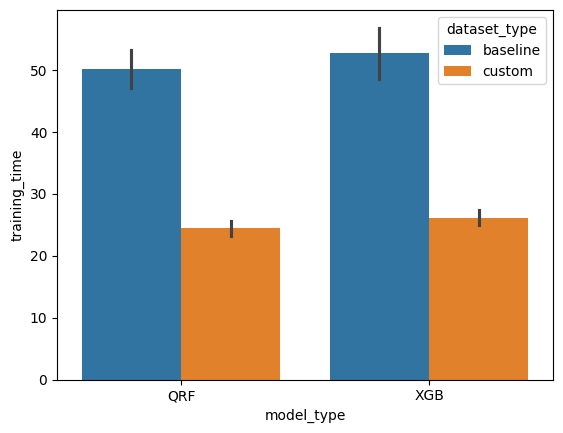

In [120]:
# Flatten into list of rows
rows = []
for dataset_type, dataset_data in summary.items():
    for model_type, times in dataset_data.get("train_times", {}).items():
        for time in times:
            rows.append(
                {
                    "dataset_type": dataset_type,
                    "model_type": model_type,
                    "training_time": time,
                }
            )

# Create DataFrame
train_time_df = pd.DataFrame(rows)

import seaborn as sns

sns.barplot(
    train_time_df,
    x="model_type",
    y="training_time",
    hue="dataset_type",
    errorbar="sd",
)

In [121]:
speedup = (
    train_time_df[train_time_df["dataset_type"] == "custom"]["training_time"].sum()
    / train_time_df[train_time_df["dataset_type"] == "baseline"]["training_time"].sum()
) * 100

print(f"Speedup with custom dataset: {speedup:.2f}%")

Speedup with custom dataset: 49.18%


In [ ]:
baseline_train_time = train_time_df[train_time_df["dataset_type"] == "baseline"]
custom_train_time = train_time_df[train_time_df["dataset_type"] == "custom"]

print(
    f"Average baseline train time : {baseline_train_time['training_time'].mean():.2f} seconds +/- {baseline_train_time['training_time'].std():.2f} seconds"
)
print(
    f"Average custom train time : {custom_train_time['training_time'].mean():.2f} seconds +/- {custom_train_time['training_time'].std():.2f} seconds"
)

Average baseline train time : 51.43 seconds +/- 3.65 seconds
Average custom train time : 25.29 seconds +/- 1.47 seconds


### NGLL


In [122]:
predictions["baseline"]

[{'model': 'QRF',
  'prediction': array([ 29.02672143,  20.20571429,  12.38642857, ..., 974.33492143,
         614.13028571, 895.39312857]),
  'dataset': 'baseline',
  'stations': array([ 6119020,  6119020,  6119020, ..., 56994500, 56994500, 56994500]),
  'prediction_interval': array([[  13.66      ,   50.43928571],
         [   9.14385714,   33.35817214],
         [   6.77428571,   18.42928571],
         ...,
         [ 588.96938857, 1479.90804643],
         [ 395.29552714,  863.40547571],
         [ 491.12914   , 1974.24245786]])},
 {'model': 'XGB',
  'prediction': array([ 31.48988914,  21.27374458,  10.93968964, ..., 672.06622314,
         843.70825195, 805.73455811]),
  'dataset': 'baseline',
  'stations': array([ 6119020,  6119020,  6119020, ..., 56994500, 56994500, 56994500]),
  'prediction_interval': array([[  17.97423129,   52.01539234],
         [  12.27374458,   38.54319125],
         [   4.75704178,   17.11417088],
         ...,
         [ 282.64418029, 1020.85410202],
     

<Axes: xlabel='model', ylabel='log_likelihood'>

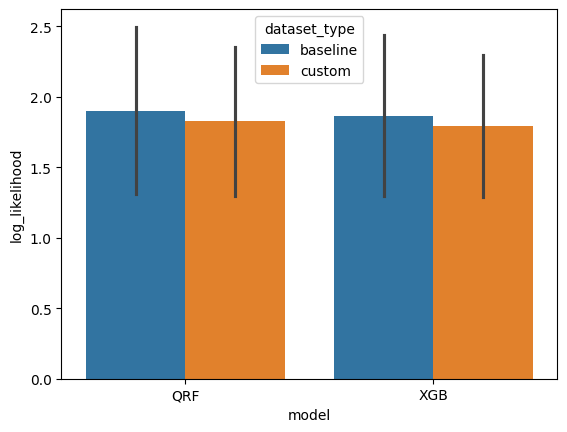

In [123]:
overall_results = pd.DataFrame()


for dataset_type in DATASET_TYPES:
    for i in range(NUMBER_OF_WEEK):
        t = compare_models_per_station(
            DATASETS[dataset_type]["y_eval"][0],
            predictions[dataset_type],
            DATASETS[dataset_type]["x_eval"]["station_code"].values,
            display=False,
            return_df=True,
        )
        t["dataset_type"] = dataset_type
        t["week"] = i
        overall_results = pd.concat([overall_results, t])

import seaborn as sns

sns.barplot(
    overall_results,
    x="model",
    y="log_likelihood",
    hue="dataset_type",
    errorbar="sd",
)

In [ ]:
from scipy.stats import ttest_rel

baseline_log_likelihood = overall_results[
    (overall_results["dataset_type"] == "baseline")
]["log_likelihood"].values
custom_log_likelihood = overall_results[(overall_results["dataset_type"] == "custom")][
    "log_likelihood"
].values

min_len = min(len(baseline_log_likelihood), len(custom_log_likelihood))

baseline_log_likelihood = baseline_log_likelihood[:min_len]
custom_log_likelihood = custom_log_likelihood[:min_len]

stat, p_value = ttest_rel(custom_log_likelihood, baseline_log_likelihood)
print(
    f"Average log-likelihood for baseline : {baseline_log_likelihood.mean()} +/- {baseline_log_likelihood.std()}"
)
print(
    f"Average log-likelihood for custom : {custom_log_likelihood.mean()} +/- {custom_log_likelihood.std()}"
)
print("difference : ", custom_log_likelihood.mean() / baseline_log_likelihood.mean())
print("p-value:", p_value)

Average log-likelihood for baseline : 1.876133985777083 +/- 0.5845815707101735
Average log-likelihood for custom : 1.809263232750005 +/- 0.5175642651594747
difference :  0.9643571549078993
p-value: 0.004147238536276774
